# Bad Beer or a Bad Pipette?  
**Fixed Measurement Error and Prior Specification in PyMC3**


The notebook reworks the pymc implementation of the cell counting model from Chapter 20 of Think Bayes 2 by Allen Downey.  The example originally comes from [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting), by Cameron Davidson-Pilon.

The basic model is: 
1. a yeast cell concentration to be inferred, 
2. a measurement error due to a number of laboratory dilution steps, and 
3. a yeast cell count observation.  

I have been struggling with this example for a while, due my conceptual model of measurement error (component #2).  To my thinking, measurement error is a quantity observed outside the model and should not be inferred by the observation.  Yet the measurement error (component #2) and the cell concentration (component #1) are treated the same way in the pymc3 model and are therefore both subject to inference.  If both the cell concentration and the measurement error are updated by the model, then the model can't tell the difference between bad beer (an out of range cell concentration), and a bad pipette (out of range measurement error)! 

To my thinking, if the measurement error is a known distribution, it should not be updated in the posterior, and the prior should match the posterior.  In updating the measurement error in the posterior, we are potentially biasing the the cell count inference (i.e., mistaking bad beer for a bad pipette)

The notebook runs through three versions of the model: 
1. A simplified version of the original model as a starting point.  
2. A rerun of the simplified model with a different observation to demonstrate my concerns.    
3. A rerun of the simplified model with a different observation and different priors to show the model working again.  

The punch line is that the prior specification is very important for keeping the measurement error consistent in the model.  

## Imports

In [57]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

# Get utils.py
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [58]:
from utils import set_pyplot_params
set_pyplot_params()
import numpy as np
from empiricaldist import Cdf
from utils import decorate
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import pandas as pd

## Simplified Yeast Counting Model 
The original model includes a number of dilution steps on the yeast slurry.  In a separate notebook, I sampled the prior to estimate the combined effect so that I could simplify the model for the purpose of this exercise.  The measurement error is combined in a single term called `effective sample volume`, which converts between `yeast concentration (cells/mL)` to `yeast visible (cells)`.  It is a very small number:   

In [59]:
# effective sample volume mean and std were determined in a separate notebook
# these values are mL
effective_sample_volume_mean = 1.e-7
effective_sample_volume_std = 5.3e-9

# Multiplying by million turns mL into nL
MILLION = 1e6
effective_sample_volume_mean * MILLION, effective_sample_volume_std * MILLION

(0.09999999999999999, 0.0053)

The pymc model then becomes the following:

In [60]:
BILLION = 1e9
TOTAL_SQUARES = 25

squares_counted = 5
yeast_counted = 49

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc (cells/mL)", mu=2 * BILLION, sd=0.4 * BILLION)
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)

    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * effective_sample_volume / MILLION)
    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


Check that the model is generally in the right range with the prior predictive.  

In [61]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T


,count,mean,std,min,25%,50%,75%,max
0,10000.0,40.0014,10.424398,5.0,33.0,40.0,47.0,87.0


Sample

In [62]:
with model:
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_5476/2081021944.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39001116318367723, but should be close to 0.8. Try to increase the number of tuning steps.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39796730991115764, but should be close to 0.8. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3852178484242033, but should be close to 0.8. Try to increase the number of tuning steps.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23927682537685158, but should be clo

Analyze posterior

In [63]:
var_names  =['effective sample volume (nL)', 'yeast conc (cells/mL)']
az.summary(trace, var_names  =var_names[0])


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),0.101,0.006,0.09,0.112,0.001,0.0,82.0,168.0,1.07


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


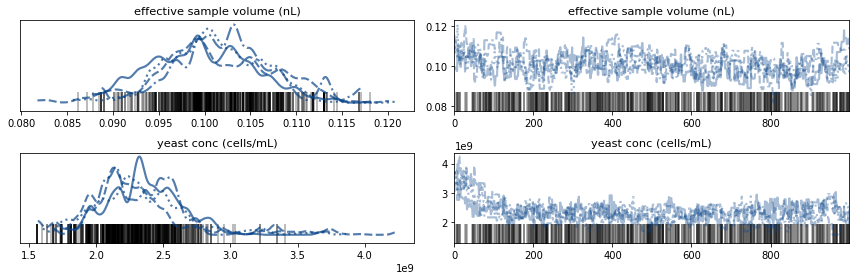

In [64]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

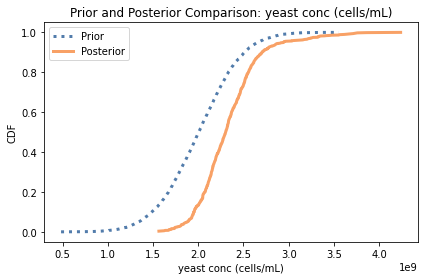

In [65]:
var = var_names[1]
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

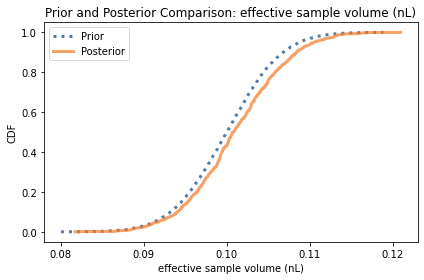

In [66]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Check posterior predictive

In [67]:
pd.DataFrame(post_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
number of counted cells,4000.0,48.055,10.334296,21.0,41.0,47.0,53.0,104.0


**Notes**  
The traces could be better, but the inference is generally OK.   

In the next version, I'll throw a "bad beer" example at the model with a higher than expected yeast observation.  

## Simplified Model with Bad Beer

Now let's assume that the yeast concentration is much larger than expected.

In [68]:
# revise yeast_counted from 49 in the example to make the value more extreme
yeast_counted = 150

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc (cells/mL)", mu=2 * BILLION, sd=0.4 * BILLION)
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)
    yeast_visible = pm.Poisson("cells in visible portion", mu=yeast_conc * effective_sample_volume / MILLION)
    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


In [69]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,40.1643,10.466521,7.0,33.0,40.0,47.0,84.0


Sample

In [70]:
with model:
    trace = pm.sample()
az.summary(trace, var_names  =var_names)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_5476/1861265075.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.4666569334106929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069265012618107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849792167051753, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a futu

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.140000e-01,5.000000e-03,1.060000e-01,1.240000e-01,0.000000e+00,0.000000e+00,591.0,1284.0,1.01
yeast conc (cells/mL),4.174756e+09,2.661814e+08,3.648164e+09,4.647996e+09,1.963791e+07,1.398311e+07,186.0,404.0,1.02


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


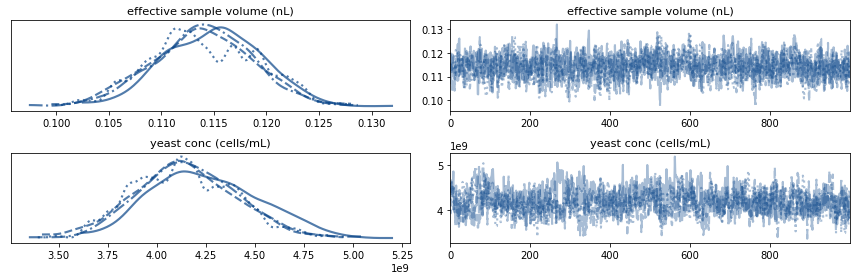

In [71]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

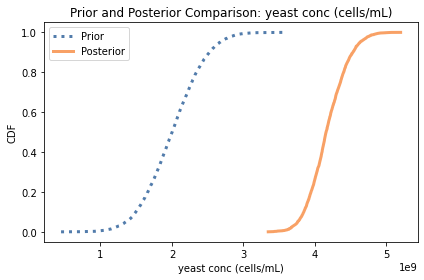

In [72]:
var = "yeast conc (cells/mL)"
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

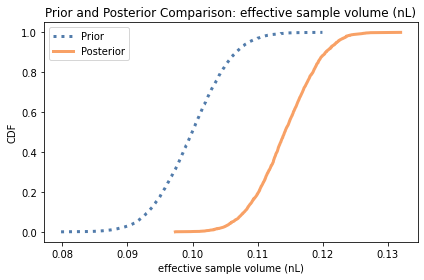

In [73]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


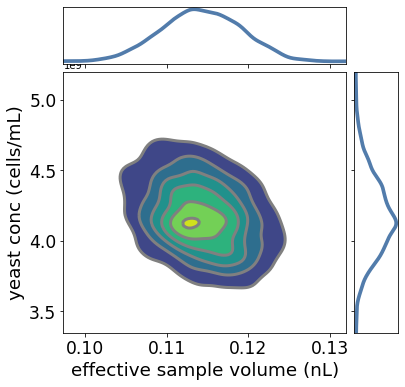

In [74]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

**Notes**  
We can see from the summary table and graphs that the model is predicting both bad beer and a bad pipette.  The cell count was much larger than expected, resulting in both the concentration and the effective sample volume to be revised.    

## Revised Model with Bad Beer and Revised Priors  

I keep thinking that there must be a way to specify the observation error to be a fixed distribution, but I have not found one.  However, in this example, I can practically fix the observation error making sure that priors on the yeast concentration are only weakly informative.  

In [75]:

with pm.Model() as model:
    # revised yeast_conc priors
    yeast_conc = pm.TruncatedNormal("yeast conc (cells/mL)", mu=6* BILLION, sd=3 * BILLION, 
                                lower = 0.5*BILLION)
                                
    effective_sample_volume = pm.TruncatedNormal("effective sample volume (nL)", lower=0,
                                            mu = effective_sample_volume_mean * MILLION,
                                            sigma =  effective_sample_volume_std * MILLION)

    yeast_visible = pm.Poisson("cells in visible portion", 
                                mu=yeast_conc * effective_sample_volume / MILLION)

    number_of_counted_cells = pm.Binomial("number of counted cells", 
                                          yeast_visible, squares_counted/TOTAL_SQUARES, 
                                          observed=yeast_counted)


In [76]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

# check prior
pd.DataFrame(prior_sample['number of counted cells']).describe().T


,count,mean,std,min,25%,50%,75%,max
0,10000.0,123.3467,56.960769,6.0,82.0,121.0,161.0,355.0


The prior is within the right range.  

In [77]:
with model:   
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)
    

az.summary(trace, var_names  =var_names)

C:\Users\GBRUNK~1\AppData\Local\Temp/ipykernel_5476/2565572135.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [effective sample volume (nL), yeast conc (cells/mL)]
>Metropolis: [cells in visible portion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effective sample volume (nL),1.000000e-01,5.000000e-03,9.000000e-02,1.100000e-01,0.00,0.000000e+00,856.0,1155.0,1.01
yeast conc (cells/mL),7.608815e+09,7.082733e+08,6.320257e+09,8.877487e+09,46823127.75,3.315125e+07,228.0,670.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


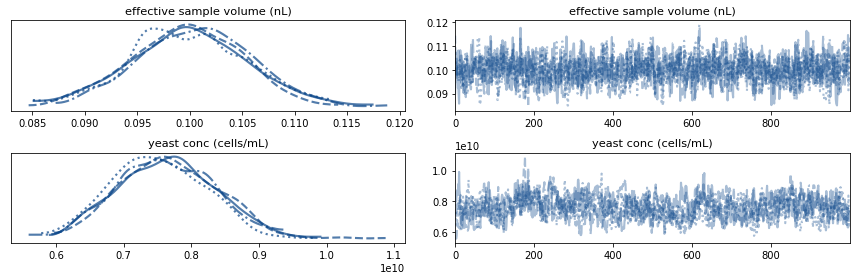

In [78]:
az.plot_trace(trace, var_names=var_names)
plt.tight_layout();

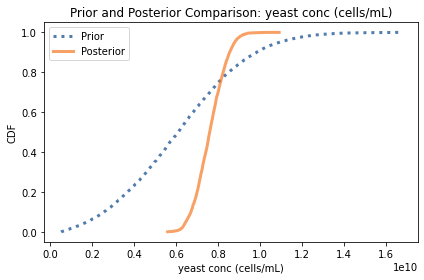

In [79]:
var = "yeast conc (cells/mL)"
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

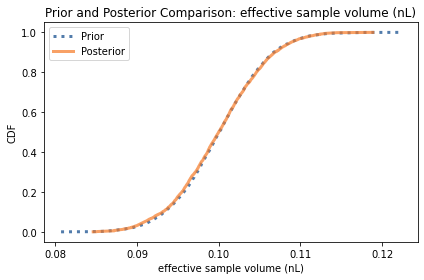

In [80]:
var = 'effective sample volume (nL)'
cdf_prior = Cdf.from_seq(prior_sample[var])
cdf_post = Cdf.from_seq(trace[var])
cdf_prior.plot(label='Prior', style=':')
cdf_post.plot(label='Posterior')
decorate(xlabel=var,
         ylabel='CDF',
         title='Prior and Posterior Comparison: '+var)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\gbrunkhorst\.conda\envs\pymc\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


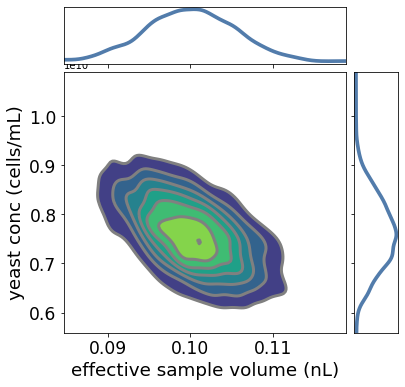

In [81]:
az.plot_pair(trace, var_names=var_names, marginals=True, kind='kde',figsize=(6,6));

# Summary
Maybe there is a way to have a fixed distribution under the hood in a pymc3 model.  I don't know how to do that.  However, with careful prior specification, the measurement error can be added to the model with the expected outcome that it will remain similar to the prior.  